## Importing packages

In [1]:
import anndata as an
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider

import scipy.stats as stats
import random
import joblib
from joblib import Parallel, delayed
import multiprocessing
import itertools
import time

import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel

from scipy.stats import norm
from scipy.optimize import minimize
import torch
import gpytorch
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

from gpytorch.constraints.constraints import Interval

import re
import os
import copy

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.lines import Line2D

## Import required classes and functions from files in src folder

In [2]:
from src.GP_models import ExactGPModel, TorchGPModel
from src.bayesian_opt_code import ucb, ES, sample_next_hyperparameter, plot_ucb_surfaces

## Load data and update GP model. The variables are defined as follows:

#### data: this is the simulated data. It is a dictionary comprising xp, yp and pseudotime_current_devices.
#### xp is a N by 3 array, where N is the number of datapoints in the dataset. Each row of xp is a 3-dimensional vector representing the data from 1 device at one measurement round, with the first entry denoting the pseudotime at that round, and the next two entries representing the (normalized) amplitude and frequency respectively of the action chosen in that round.
#### yp is a N by 1 array. The i-th entry of yp represents the change in pseudotime measured corresponding to taking the action xp[i,1:] starting at the pseudotime xp[i,0].
#### s is defined as data['pseudotime_current_devices']. It is a m-dimensional vector comprising the pseudotimes of m devices for which we wish to select new actions at the current round. In the simulated dataset, m = 3.

In [3]:
data = np.load('test_data/data.npz')
xp = data['xp'] 
yp = data['yp']
s = data['pseudotime_current_devices']
model = TorchGPModel(torch.tensor(xp).float(), torch.tensor(yp).float())

## Set parameters. Variables are defined as follows.
### bounds: bounds on the state/pseudotime (first dimension) and action space (2-dimensional). 
### batch_size: number of points to sample in parallel in one round (this is the same as the m parameter we introduced earlier)
### s_dim: dimension of the pseudotime (1-dim in this problem)
### a_dim: dimension of the action (2-dim in this problem)

In [4]:
bounds = np.asarray([[0,1],[0,1],[0,1]])
batch_size = 3
s_dim = 1
a_dim = 2

## Perform parallel Entropy Search to select next acquisition points 

### First, we compute for each of m devices (note we use m and batch_size interchangeably) the action that maximizes an upper-confidence bound, using the function sample_next_hyperparameter. This new proposed action, along with the pseudotime of the corresponding datapoint, is stored in the variable new_sa.

In [88]:
manual_seed = 0
new_sa = np.empty((batch_size, s_dim + a_dim))
yp = np.copy(yp)
for i in range(batch_size):
    new_sa[i,s_dim:] = sample_next_hyperparameter(s[i], model, yp, acquisition_func = ucb,acq = "ucb",greater_is_better=True, 
                                                   bounds=bounds, seed = manual_seed)
    new_sa[i,:s_dim] = s[i]

### Next, we run the function ES to perform a parallel entropy search that seeks to maximize the information gain about the proposed ucb actions (at the corresponding pseudotime values). The output of this function is the new proposed actions. We then update the variable next_sa such that its actions comprise the new proposed actions.

In [89]:
a_new = ES( new_sa,
            model,
            state_dim=1,
            n_params=2,
            beta=0.2,
            alpha=0.0,
            a_circ=0.2,
            tr_iters=20,
            domain=bounds[0, :],
           seed = manual_seed
        )
new_sa[:, s_dim:] = a_new

best a [[0.46416932 0.5517467 ]
 [0.0193701  0.80518305]
 [0.31677425 1.        ]]


## Print proposed proposal of new actions to sample 

In [101]:
print(
    f"device joint proposal after using ES: ",
    new_sa[:, s_dim:])
print("state is ",
    s)

device joint proposal after using ES:  [[0.0193701  0.80518305]
 [0.31677425 1.        ]
 [0.46416932 0.55174673]]
state is  [0.4 0.4 0.4]


## Visualization

### For the purposes of this demo, we generate some random data to represent the change in pseudotime when we take the new actions in next_sa.

In [116]:
y_new = [0.05,0.05,0.05]

### We then update the xp and yp data to include the new data (new_sa, y_new)

In [117]:
xp = np.vstack([xp, new_sa])

# Add the new entry to y
yp = np.append(yp, y_new)

### We then update the GP model

In [118]:
new_model = TorchGPModel(torch.tensor(xp).float(), torch.tensor(yp).float())

### For visualization purposes, we compare the prior GP belief (before adding the new data) and posterior GP belief (after adding the new data). To make the plot visualizable in 3D, we fix the pseudotime to be 0.4, which is also the pseudotime value for the 3 devices at the current round (in general, the devices can have different pseudotimes, but for visualization purpose, we picked them to share the same pseudotime in this simulation).

#### elev and azim are tunable parameters controlling the viewing angle of the 3d plot.

/var/folders/th/7rbqk5hj5zs8zc9bfnfj4_0h0000gp/T/ipykernel_59287/2545484827.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu[k,i,j], std[k,i,j] = model.predict(np.asarray([pt,A1[i,j], A2[i,j]]), return_std = True)


l=0 0.019370101392269135 0.8051830530166626 0.05
l=1 0.31677424907684326 1.0 0.05
l=2 0.46416932344436646 0.5517467260360718 0.05


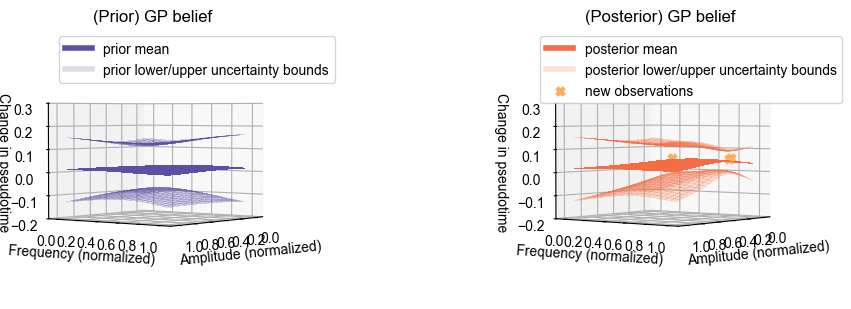

In [144]:
plt.close()
elev =2
azim = 38
pseudotime = 0.4
plot_ucb_surfaces(N = 20, pt = pseudotime, models = [model, new_model], elev = elev, azim = azim, 
    plot_ucb = True, common_zaxis = True, same_color = False,
    n_new = batch_size, plot_poly = False, Xnew = new_sa[:,s_dim:], Ynew =  y_new, stride = 1)

### Above, the middle surface represents the GP mean, whilst the lower and upper surfaces represent the lower and upper uncertainty bounds. As we can see, the new observations has a role in changing both the GP mean as well as reducing the uncertainty in the region near where the points are sampled.